# Прогнозирование оттока клиента в телеком компании

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Наша задача — обучить на этих данных модель для прогноза оттока клиентов.

Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

Цель исследования: Обучить модель для проноза оттока клиентов (ROC_AUC >= 0.85)

Ход исследования:

1. Загрузка данных
2. Исследовательский анализ и предобработка данных
3. Объединение данных
4. Исследовательский анализ и предобработка данных объединённого датафрейма
5. Подготовка данных
6. Обучение моделей машинного обучения
7. Выбор лучшей модели
8. Общий вывод и рекомендации заказчику




In [ ]:
#Код ревьюера
!pip install scikit-learn==1.1.3

In [ ]:
! pip install catboost
! pip install phik
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from functools import reduce
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import (
    cross_val_score,
    RandomizedSearchCV,
    train_test_split
)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from catboost import CatBoostClassifier

import phik
from phik.report import plot_correlation_matrix

import warnings
warnings.filterwarnings("ignore")

## Загрузка данных

In [ ]:
# загружаем рабочие файлы
try:
    contract = pd.read_csv('/datasets/contract_new.csv')
except:
    contract = pd.read_csv('https://code.s3.yandex.net//datasets/contract_new.csv')

contract.name = 'contract'

try:
    personal = pd.read_csv('/datasets/personal_new.csv')
except:
    personal = pd.read_csv('https://code.s3.yandex.net//datasets/personal_new.csv')

personal.name = 'personal'

try:
    internet = pd.read_csv('/datasets/internet_new.csv')
except:
    internet = pd.read_csv('https://code.s3.yandex.net//datasets/internet_new.csv')

internet.name = 'internet'

try:
    phone = pd.read_csv('/datasets/phone_new.csv')
except:
    phone = pd.read_csv('https://code.s3.yandex.net//datasets/phone_new.csv')

phone.name = 'phone'

In [ ]:
# датафрейм с информацией о договорах
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [ ]:
# датафрейм с персональными данными клиентов
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
# датафрейм с информацией об интернет услугах
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
# датафрейм с информацией об услугах телефонии
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


## Исследовательский анализ и предобработка данных

### Обзор данных

**contract** - информация о договорах

- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

**personal** - персональные данные клиентов

- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

**internet** - информация ою интернет услугах

- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

**phone** - информация об услугах телефонии
- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

In [ ]:
print('Contract:')
contract.info()

print('\n\n\nPersonal:')
personal.info()

print('\n\n\nInternet:')
internet.info()

print('\n\n\nPhone:')
phone.info()

Contract:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB



Personal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 n

**Выводы**:
1. Названия полей указаны в "верблюжьем стиле", поменяем его на "змеиный".
2. Явных пропусков в данных нет.
3. Некоторые столбцы имеют неверный тип данных, поменяем их:
  - BeginDate - datetime
  - EndDate - datetime
  - TotalCharges - float


### Изменение названий полей

In [ ]:
for df in [contract, personal, internet, phone]:
  df.rename({'StreamingTV':'streaming_tv', 'customerID':'customer_id'}, axis=1, inplace=True)
  df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df.columns]
  print(df.name, '\n', df.columns, '\n')

contract 
 Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object') 

personal 
 Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object') 

internet 
 Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object') 

phone 
 Index(['customer_id', 'multiple_lines'], dtype='object') 



**Вывод:** Мы поменяли названия полей с "верблюжбего" стиля на "змеиный".

### Изменение типов данных

In [ ]:
# изменим тип поля "begin_date"
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')

При обзоре датафрема contract мы видели значения в поле `end_date` не являющиеся датами. Выведем содержимое поля `end_date`.

In [ ]:
contract['end_date'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

Лишнее только одно значение - "no". Поменяем его на NaN и изменим тип поля.

In [ ]:
contract['end_date'] = contract['end_date'].replace("No", np.NaN)
contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d')

Сделаем тоже самое с полем `total_charges`. Выведем не числовые значения.

In [ ]:
contract.loc[pd.to_numeric(contract['total_charges'], errors='coerce').isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,


Видим лишнее значение - " ". Заменим его на NaN, изменим тип столбца и выведем результат.

In [ ]:
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


В таблице `personal` отдельно проверим признак `senior_citizen`.

In [ ]:
personal['senior_citizen'].unique()

array([0, 1])

Признак бинарный, значит для удобства переведем его в строковый тип (1 - 'Yes', 0 - 'No').

In [ ]:
personal['senior_citizen'] = personal['senior_citizen'].replace([0, 1], ['No', 'Yes'])
personal['senior_citizen'].unique()

array(['No', 'Yes'], dtype=object)

**Вывод:**

Мы изменили тип данных у следующих строк:
- begin_date - datetime
- end_date - datetime
- total_charges - float
- senior_citizen - object

В процессе преобразования поля `total_charges` мы допустили 11 пропущенных значений, также допустили множество пропусков в поле `end_date`, обработем их.

### Обработка пропущенных значений

In [ ]:
# выведем пропуски 'total_charges'
contract[contract['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN


Строки с пропусками имеют одну дату "2020-02-01" - это последняя дата выгрузки данных. Видимо данные в этих строках не заполнены, т.к. общие расходы клиента еще не успели сформироваться. Проверим, касается ли это всех клиентов с данной датой заключения договора.

In [ ]:
contract[contract['begin_date'] == '2020-02-01']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN


Получили те же самые 11 строк. Значит у всех, кто заключил договор в этот день общие расходы не сформировались. Можем попробовать заменить эти данные месячными расходами, но для начала проверим, верно ли, что для всех клиентов месячные расходы меньше чем общие.

In [ ]:
(contract['monthly_charges'] <= contract['total_charges']).sum()

7032

Получили количество строк без пропусков, значит можем заменить.

In [ ]:
contract.loc[contract['begin_date'] == '2020-02-01', 'total_charges'] = contract.loc[contract['begin_date'] == '2020-02-01', 'monthly_charges']
contract[contract['begin_date'] == '2020-02-01']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,52.55
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,20.25
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,80.85
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,25.75
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,56.05
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,19.85
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,25.35
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,20.00
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,19.70
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,73.35


**Вывод**: Пропуски в столбце `total_charges` обработаны.

Пропуски в поле `end_date` обработывать не будем. Они значат, что срок действия договора не истек, либо клиент не расторгнул его. Это поле понадобится нам для формирования целевого признака.

### Анализ таблиц

In [ ]:
contract.describe(include='all', datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
customer_id,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
begin_date,7043,NaN,NaN,NaN,2017-04-30 13:01:50.918642688,2013-10-01 00:00:00,2015-06-01 00:00:00,2017-09-01 00:00:00,2019-04-01 00:00:00,2020-02-01 00:00:00,NaN
end_date,1101,NaN,NaN,NaN,2018-03-12 18:21:15.204359680,2014-06-01 00:00:00,2017-05-01 00:00:00,2018-06-01 00:00:00,2019-04-01 00:00:00,2020-01-01 00:00:00,NaN
type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
paperless_billing,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_method,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
monthly_charges,7043.0,NaN,NaN,NaN,64.761692,18.25,35.5,70.35,89.85,118.75,30.090047
total_charges,7043.0,NaN,NaN,NaN,2115.377573,19.05,436.75,1343.35,3236.69,9221.38,2112.678861


Таблица состоит из полей разного типа. Видим диапазоны числовых значений и datetime. В столбце `customer_id` только уникальные значения.
Проверим значения категоральных признаков:

In [ ]:
for i in contract.select_dtypes(include='object').columns:
  if i != 'customer_id':
    print(i, contract[i].unique())

type ['Month-to-month' 'One year' 'Two year']
paperless_billing ['Yes' 'No']
payment_method ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


Все в порядке.

In [ ]:
personal.describe().T

,count,unique,top,freq
customer_id,7043,7043,7590-VHVEG,1
gender,7043,2,Male,3555
senior_citizen,7043,2,No,5901
partner,7043,2,No,3641
dependents,7043,2,No,4933


Таблица состоит из категоральных полей. В поле `customer_id` только уникальные значения. Рассмотрим остальные поля (в оставшихся таблицах ситуация аналогична):

In [ ]:
for i in personal.select_dtypes(include='object').columns:
  if i != 'customer_id':
    print(i, personal[i].unique())

gender ['Female' 'Male']
senior_citizen ['No' 'Yes']
partner ['Yes' 'No']
dependents ['No' 'Yes']


In [ ]:
internet.describe().T

,count,unique,top,freq
customer_id,5517,5517,7590-VHVEG,1
internet_service,5517,2,Fiber optic,3096
online_security,5517,2,No,3498
online_backup,5517,2,No,3088
device_protection,5517,2,No,3095
tech_support,5517,2,No,3473
streaming_tv,5517,2,No,2810
streaming_movies,5517,2,No,2785


In [ ]:
for i in internet.select_dtypes(include='object').columns:
  if i != 'customer_id':
    print(i, internet[i].unique())

internet_service ['DSL' 'Fiber optic']
online_security ['No' 'Yes']
online_backup ['Yes' 'No']
device_protection ['No' 'Yes']
tech_support ['No' 'Yes']
streaming_tv ['No' 'Yes']
streaming_movies ['No' 'Yes']


In [ ]:
phone.describe().T

,count,unique,top,freq
customer_id,6361,6361,5575-GNVDE,1
multiple_lines,6361,2,No,3390


In [ ]:
print('multiple_lines', phone['multiple_lines'].unique())

multiple_lines ['No' 'Yes']


**Вывод:**
Мы рассмотрели описания столбцов. Увидели какие значения хранятся в них. Подробный анализ проведем после объединения датафреймов.

Отметим что поля в таблицах `internet` и `phone` предусматривают наличие услуг интернета и телефонии у клиента. Т.к. строк, а значит и пользователей в этих таблицах меньше, будем считать, что отсутствующие пользователи не используют интернет или телефонию. В дальнейшем, при объединении таблиц, заполним пустые значения строкой "other".

## Объединение датафреймов

In [ ]:
# объединим датафреймы по столбцу customer_id
data = reduce(lambda  left,right: pd.merge(left,right,on='customer_id',
                                            how='left'), [contract, personal, internet, phone])
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


In [ ]:
# поля и пропуски
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

**Вывод:** Все таблицы вошли в итоговый датафрейм в полном составе.

## Исследовательский анализ и предобработка данных объединённого датафрейма

### Целевая переменная

Используем столбец `end_date` для создания целевой переменной. Назовем её `outflow` (отток).

In [ ]:
data['outflow'] = np.where(~data['end_date'].isna(), 1, 0)
data['outflow'].value_counts()

0    5942
1    1101
Name: outflow, dtype: int64

1 - это отток, а 0 - это те кто остался.

### Обработка пропущенных значений

In [ ]:
# количество пропусков
data.isna().sum()

customer_id             0
begin_date              0
end_date             5942
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
outflow                 0
dtype: int64

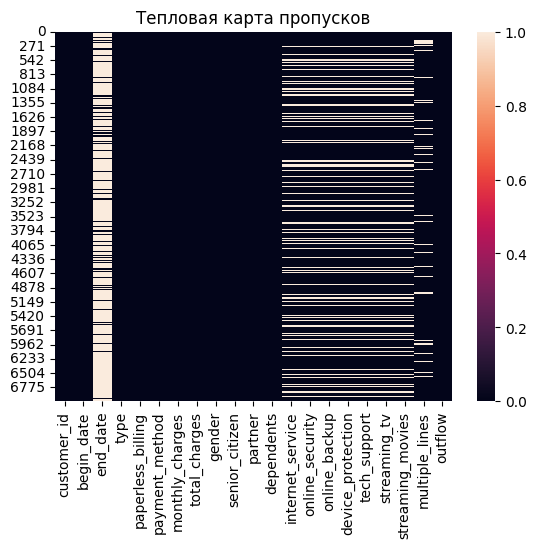

In [ ]:
# тепловая карта пропусков
sns.heatmap(data.isnull())
plt.title("Тепловая карта пропусков")
plt.show()

Мы знаем, что пропуски обнаружены в полях из таблиц `internet` и `phone`.
Ранее мы договаривались, что заполним эти пропуски словом "other".

In [ ]:
data.iloc[:, 12:] = data.iloc[:, 12:].fillna('other')
data.isna().sum()

customer_id             0
begin_date              0
end_date             5942
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
multiple_lines          0
outflow                 0
dtype: int64

**Вывод:** Мы обработали пропуски во всех полях из исходных таблиц `internet` и `phone`. Пустые значения были заменены словом "other". Пропуски в поле `end_date` мы трогать не будем, т.к. мы удалим данное поле за ненадобностью (данное поле вызывает утечку признака).

### Создание новых признаков

Создадим новый признак - длительность действия договора. Пустые значения `end_date` мы заполним последней датой выгрузки данных `2020-02-01`. После создания этого признака удалим ненужные поля:
- end_date (утечка таргета)
- begin_date (не нужно для модели)
- customer_id (не нужно для модели)

In [ ]:
data['end_date'] = data['end_date'].fillna(pd.to_datetime('2020-02-01', format='%Y-%m-%d'))
data['duration'] = (data['end_date'] - data['begin_date']).dt.days

data = data.drop(['customer_id', 'begin_date', 'end_date'], axis=1)

### Анализ признаков

Для начала изучим целевой признак `outflow`.

In [ ]:
data['outflow'].value_counts(normalize=True)

0    0.843675
1    0.156325
Name: outflow, dtype: float64

Количество ушедших клиентов равно 16%, а оставшихся 84%. Наблюдается явный дисбаланс классов. Положительный класс в меньшинстве.

Построим распределения числовых признаков.

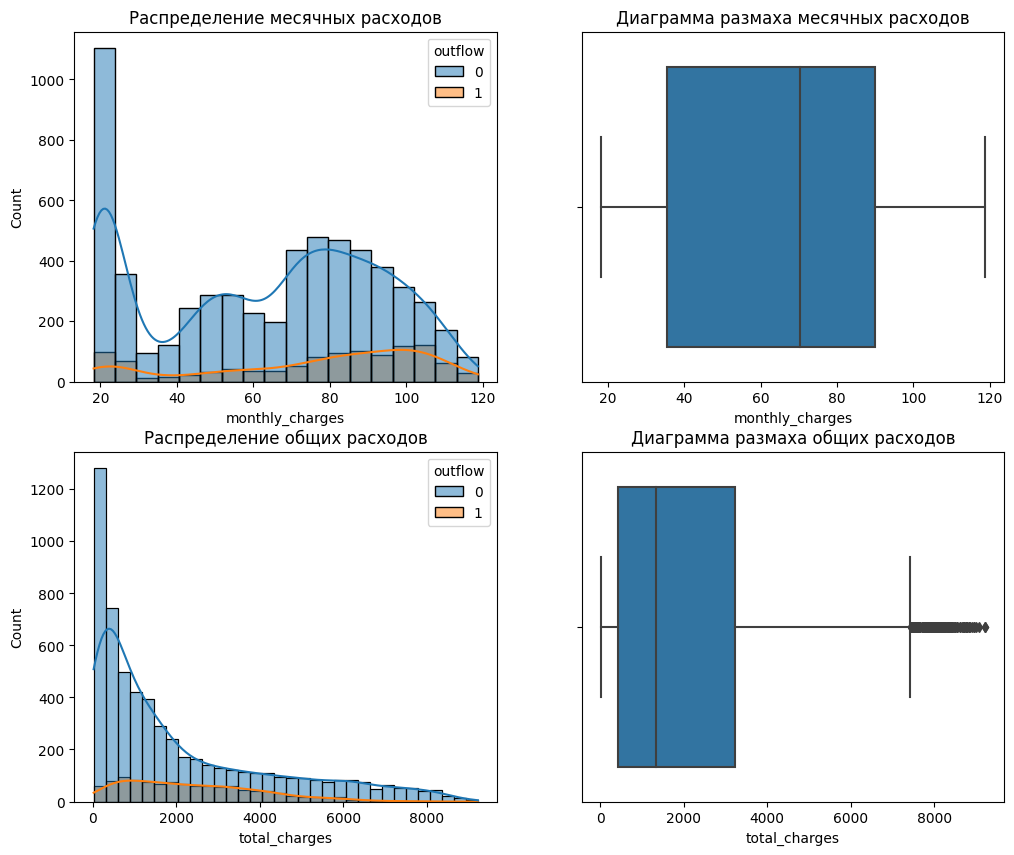

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(data=data, x = 'monthly_charges', kde=True, hue='outflow', ax=axes[0, 0])
sns.boxplot(data=data, x = 'monthly_charges', ax=axes[0, 1])
sns.histplot(data=data, x = 'total_charges', kde=True, hue='outflow', ax=axes[1, 0])
sns.boxplot(data=data, x = 'total_charges', ax=axes[1, 1])

axes[0, 0].set_title("Распределение месячных расходов")
axes[1, 0].set_title("Распределение общих расходов")
axes[0, 1].set_title("Диаграмма размаха месячных расходов")
axes[1, 1].set_title("Диаграмма размаха общих расходов")

plt.show()

**Выводы:**
- На распределении месячных расходов видно, что оставшиеся клиенты предпочитают либо платить в районе 20 у.е. (большой пик), либо от 70 до 100.
У ушедших же клиентов большая часть платила ежемесячно от 70 до 105 у.е. График менее волнистый, явных пиков нет.
Т.е. ушедшие клиенты в месяц предпочитали платить больше чем оставшиеся.

- Распределение общих расходов у ушедших клиентов также более сглаженное чем у оставшихся. У них нет пика начале координат графика. Ушедшие клиенты более активно пользовались услугами оператора.

- Признак с месячными расходами не имеет выбросов, а с общими имеет выбросы после 7500. Удалять выбросы мы не будем, т.к. можем допустить такие большие траты клиентов. Модель должна учиться на этих данных.

Построим распределения категоральных признаков.

In [ ]:
# функция для нормирования категорального признака
def categorial_plot(data, column):
  fig, axes = plt.subplots(1, 2, figsize=(10, 3))
  categorial = pd.crosstab(index=data[column], columns=data['outflow'], normalize='index')
  categorial.plot(kind='bar', stacked=True, ax=axes[0])
  sns.countplot(data=data.sort_values(column), x=column, hue='outflow')
  plt.suptitle('Отток по ' + column)
  plt.sca(axes[1])
  plt.xticks(rotation='vertical')

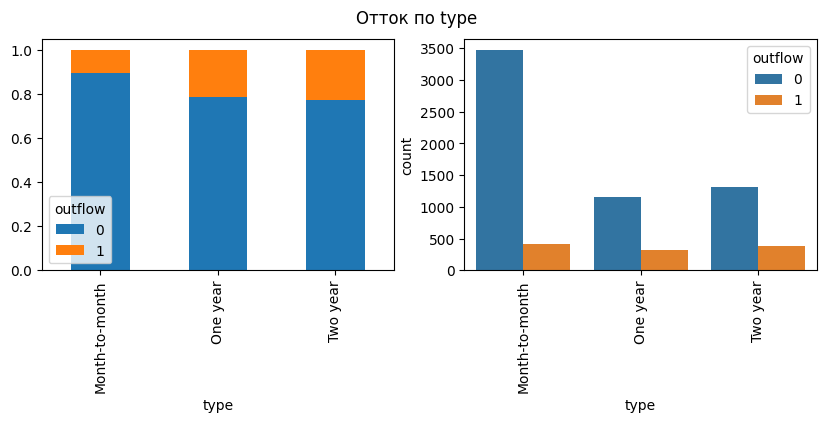

In [ ]:
categorial_plot(data, 'type')

Ушедшие клиенты используют разные типы оплаты почти в равной степени, но клиенты оплачивающие счет раз в один-два года чаще разрывают контракт.

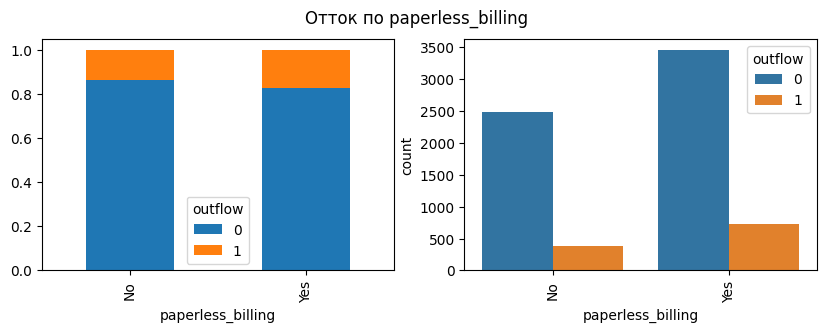

In [ ]:
categorial_plot(data, 'paperless_billing')

Чуть больше ушедших клиентов пользовались электронным расчетным листом.
 Доли почти равны. Связь не наблюдается.

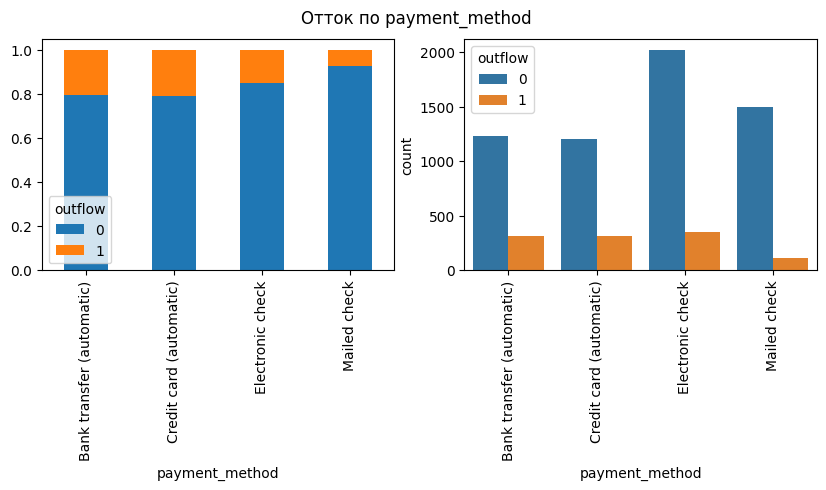

In [ ]:
categorial_plot(data, 'payment_method')

Люди пользующиеся автоматическими списаниями либо со счета либо с кредитной карты чаще разрывают контракт. Ушедшие клиенты в меньшей степени предпочитали оплачивать по почте.

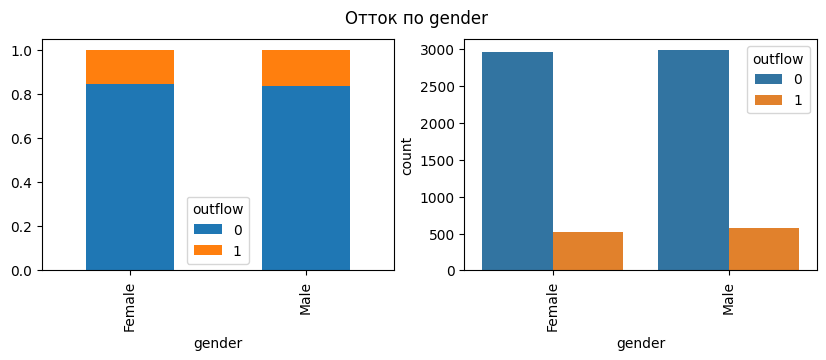

In [ ]:
categorial_plot(data, 'gender')

Количество и доли почти равны. Связь не наблюдается.

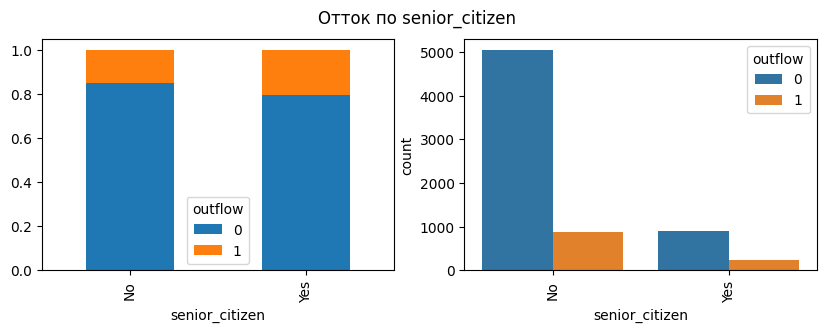

In [ ]:
categorial_plot(data, 'senior_citizen')

Доля ушедших клиентов среди пенсионеров немного больше, это может быть связано с возрастом.

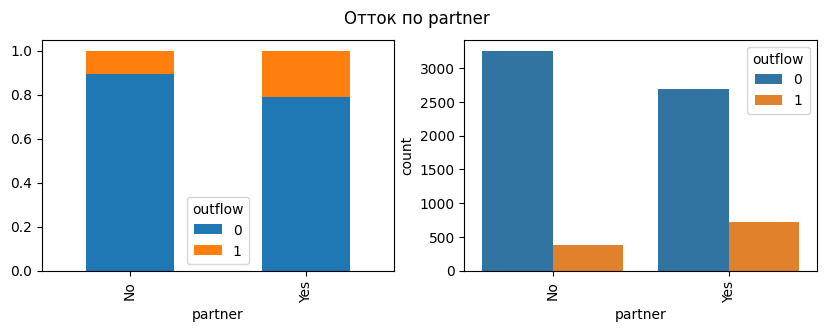

In [ ]:
categorial_plot(data, 'partner')

Женатые люди чаще разрывают контракт. Это может быть связано с отсутствием у компании выгодных тарифов для нескольких человек и для разных устройств (семейный тариф, Телефония + интернет + ТВ).

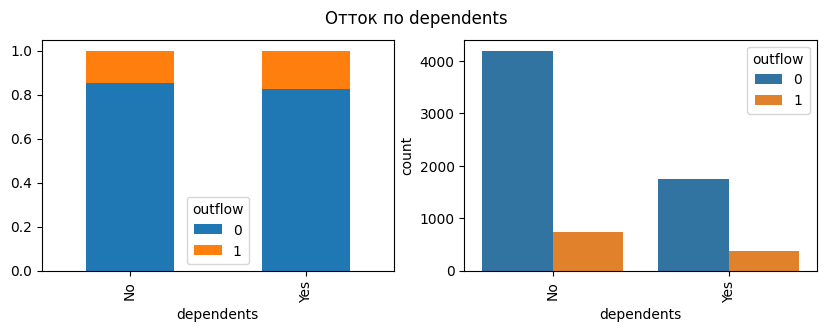

In [ ]:
categorial_plot(data, 'dependents')

Доли почти равны. Зависимость не наблюдается.

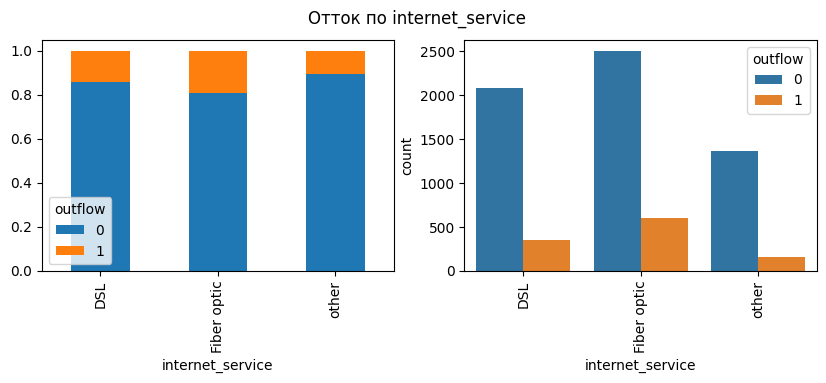

In [ ]:
categorial_plot(data, 'internet_service')

Доля ушедших клиентов использующих оптиволокно чуть больше чем у DSL и остальных. Возможно клиентов не устраивает его скорость.

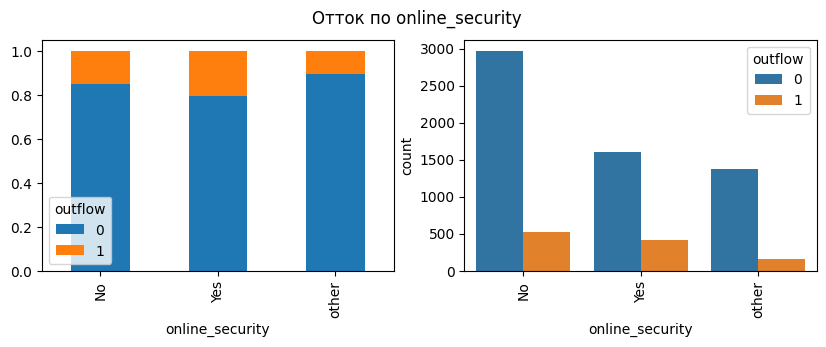

In [ ]:
categorial_plot(data, 'online_security')

Доля ушедших клиентов подключивших блокировку опасных сайтов чуть больше, чем тех у которых эта услуга не подключена. Возможно не устраивает качество услуги. Следующие графики отражают аналогичную ситуацию по соответствующему параметру.

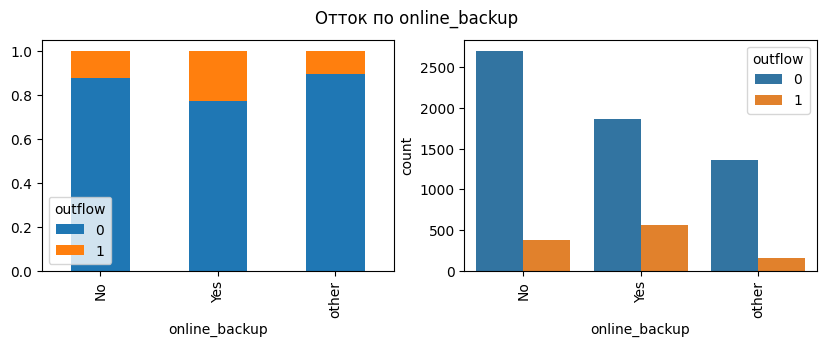

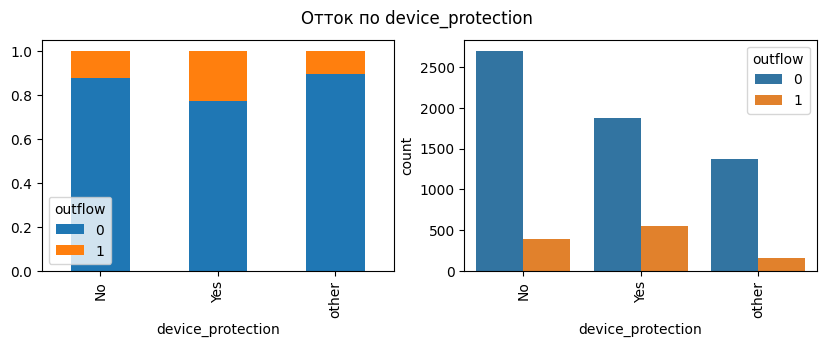

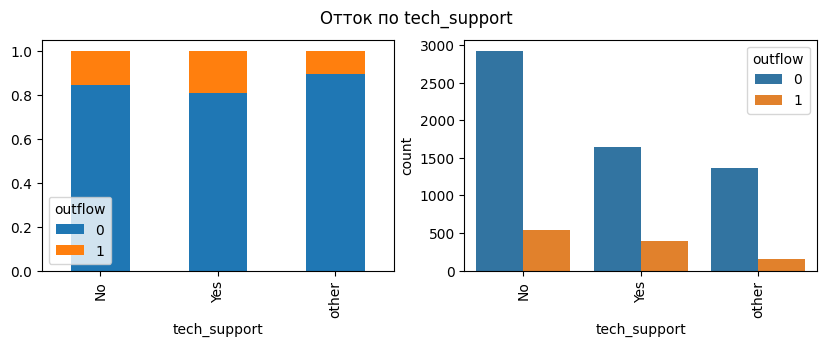

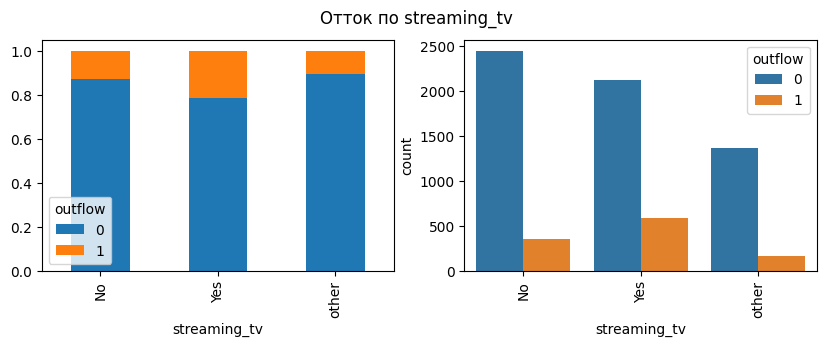

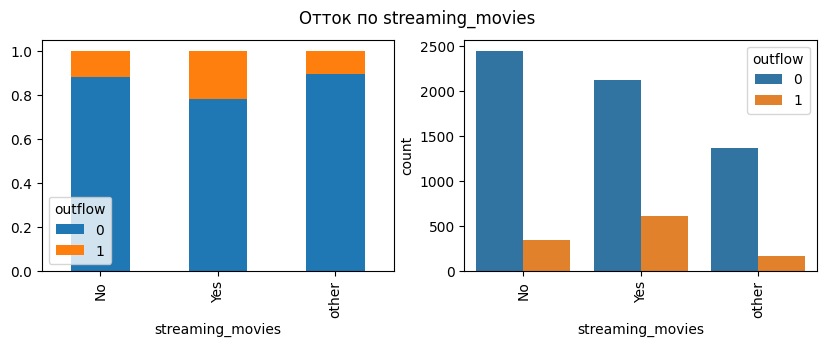

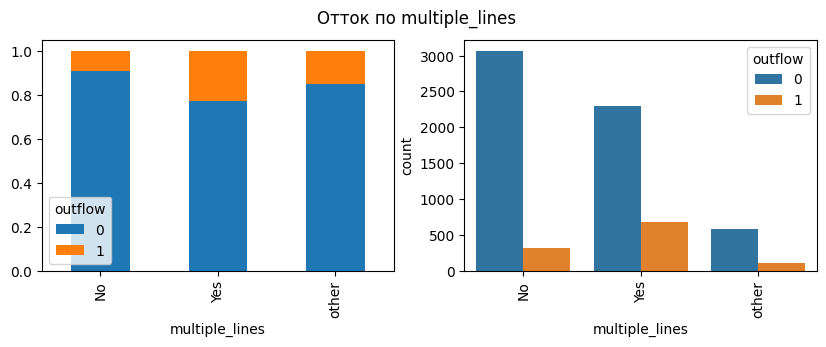

In [ ]:
categorial_plot(data, 'online_backup')
categorial_plot(data, 'device_protection')
categorial_plot(data, 'tech_support')
categorial_plot(data, 'streaming_tv')
categorial_plot(data, 'streaming_movies')
categorial_plot(data, 'multiple_lines')

**Вывод:** Таким образом видим что уходящий клиент препочитает пользоваться всем спектром услуг компании. Из-за этого средний чек больше чем у оставшихся клиентов. Возможно что уход такого клиента продиктован несоответствием ожидаемого с реальностью. Это женатый клиент. Пенсионеры более склонны к уходу.
Уходящий клиент склонен оплачивать услуги раз в год-два.

### Анализ корреляций

Построим тепловую карту.

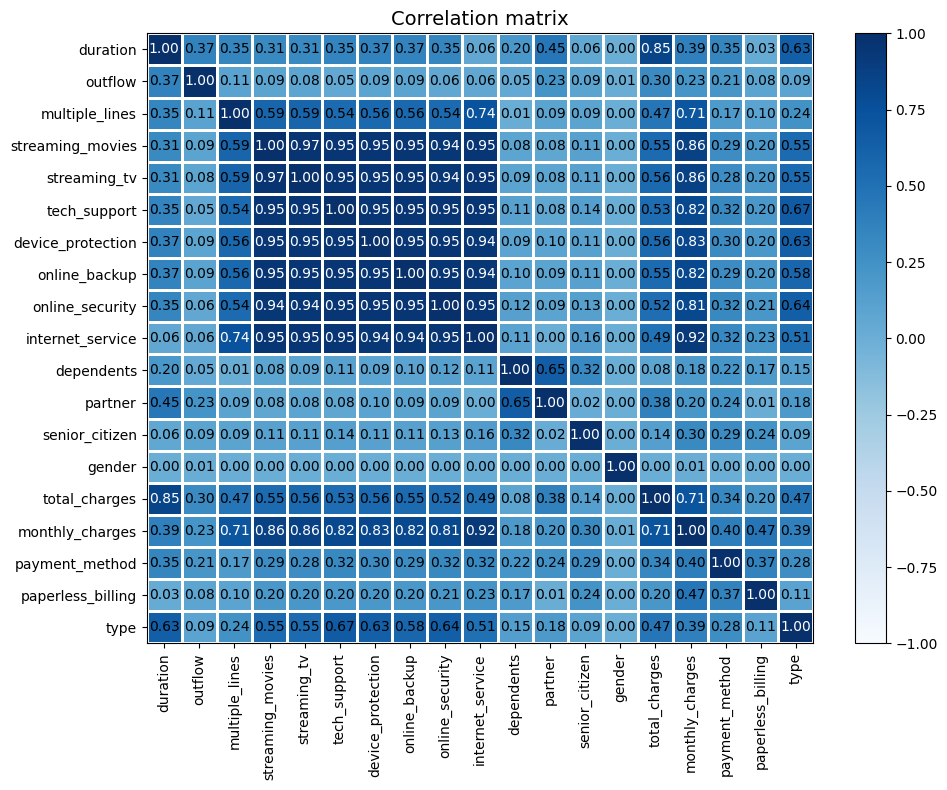

In [ ]:
matrix = data.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'duration'])
plot_correlation_matrix(matrix.values, x_labels=matrix.columns, y_labels=matrix.index, figsize=(10,8), color_map='Blues', title=r'Correlation matrix')

Удалим признаки с низкой корреляцией с целевой переменной, т.к. они предоставляют минимальную информацию о ней. Удалим все признаки с коэффициентом корреляции < 0.09.

In [ ]:
data = data.drop(['gender', 'dependents', 'tech_support', 'online_security', 'internet_service', 'paperless_billing', 'streaming_tv'], axis=1)

**Выводы:**

В результате анализа корреляций мы удалили следующие признаки: 'gender', 'dependents', 'tech_support', 'online_security', 'internet_service', 'paperless_billing', 'streaming_tv.


## Подготовка данных

In [ ]:
RANDOM_STATE = 271123

# разбиение на обучающую и тестовую выборки в соотношении (75:25)
# для сохранения баланса классов используем перемешивание со стратификацией по целевой переменной

features = data.drop(['outflow'], axis=1)
target = data['outflow']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, train_size=0.75, random_state=RANDOM_STATE, stratify=target)

## Обучение моделей

### Логистическая регрессия

In [ ]:
# используем class_weight='balanced' чтобы придать меньшему классу больший вес
model_reg = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', max_iter=1000)

#категориальные признаки
# для модели линейной регрессии кодируем все признаки методом OHE
cat_features = features_train.select_dtypes(include='object').columns.to_list()

# численные признаки (создадим одну переменную для всех моделей)
num_features = features_train[['monthly_charges', 'total_charges', 'duration']].columns.to_list()

# используем функцию make_column_transformer для предварительной обработки столбцов
# drop='first' удаляет первый признак из закодированных, таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore': игнорируется ранее невстречающиеся значения признака (при transform)
transformer_reg = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        cat_features
    ),
    (
        StandardScaler(),
        num_features
    )
)


# передаем предварительно обработанные данные в модель машинного обучения с помощью `make_pipeline`
pipeline_reg = make_pipeline(transformer_reg, model_reg)

# используем метод кросс-валидации
cv_reg_results = cross_val_score(pipeline_reg, features_train, target_train, scoring='roc_auc', error_score='raise')

print('ROC_AUC:', cv_reg_results.mean())

ROC_AUC: 0.773027403890926


### Случайный лес

In [ ]:
# случайный лес
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

transformer_rf = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        cat_features
    ),
    (
        StandardScaler(),
        num_features
    )
)

pipeline_rf = make_pipeline(transformer_rf, model_rf)

# сетка гиперпараметров для обучения модели
param_grid_rf = {
    'randomforestclassifier__n_estimators': range(10, 101, 10),
    'randomforestclassifier__max_depth': range(2, 15),
}


# используем RandomizedSearchCV т.к присутствует много параметров при переборе
# и он работает быстрее чем GridSearchCV
rs_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_grid_rf,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

#Обучение модели
rs_rf.fit(features_train, target_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('ordinalencoder',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['type',
                                                                                'payment_method',
                                                                                'senior_citizen',
                                                                                'partner',
                                                                                'online_backup',
                                                                                'device_protection',
                                                                                'streaming_movies',
                                                                                'multiple_lines']),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['monthly_charges',
                                                                                'total_charges',
                                                                                'duration'])])),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=271123))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(2, 15),
                                        'randomforestclassifier__n_estimators': range(10, 101, 10)},
                   random_state=271123, scoring='roc_auc')

In [ ]:
print(f'Лучший ROC_AUC: {rs_rf.best_score_}')
print(f'Лучшие параметры: {rs_rf.best_params_}')

Лучший ROC_AUC: 0.8365012410318297
Лучшие параметры: {'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__max_depth': 7}


### Градиентный бустинг (CatBoost)

In [ ]:
model_boost = CatBoostClassifier(random_state=RANDOM_STATE,
                                 verbose=False)

# используем трансформер для случайного леса
pipeline_boost = make_pipeline(transformer_rf, model_boost)

param_grid_boost = {
    'catboostclassifier__iterations': range(500, 3001, 500),
    'catboostclassifier__max_depth': range(2, 16),
    'catboostclassifier__learning_rate': [0.001, 0.01, 0.1, 1]
}

gs_boost = RandomizedSearchCV(
    pipeline_boost,
    param_distributions=param_grid_boost,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

gs_boost.fit(features_train, target_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('ordinalencoder',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['type',
                                                                                'payment_method',
                                                                                'senior_citizen',
                                                                                'partner',
                                                                                'online_backup',
                                                                                'device_protection',
                                                                                'streaming_movies',
                                                                                'multiple_lines']),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['monthly_charges',
                                                                                'total_charges',
                                                                                'duration'])])),
                                             ('catboostclassifier',
                                              <catboost.core.CatBoostClassifier object at 0x7ac300a22b60>)]),
                   n_jobs=-1,
                   param_distributions={'catboostclassifier__iterations': range(500, 3001, 500),
                                        'catboostclassifier__learning_rate': [0.001,
                                                                              0.01,
                                                                              0.1,
                                                                              1],
                                        'catboostclassifier__max_depth': range(2, 16)},
                   random_state=271123, scoring='roc_auc')

In [ ]:
print(f'Лучший ROC_AUC: {gs_boost.best_score_}')
print(f'Лучшие параметры: {gs_boost.best_params_}')

Лучший ROC_AUC: 0.8955981677245097
Лучшие параметры: {'catboostclassifier__max_depth': 8, 'catboostclassifier__learning_rate': 0.1, 'catboostclassifier__iterations': 1000}


**Вывод:**

Мы рассмотрели три модели со следующими результатами:
- Логистическая регрессия: 0.773027403890926
- Случайный лес: 0.8365012410318297
- Градиентный бустинг (CatBoost): 0.8955981677245097

Лучшей оказалось модель градиентного бустинга с параметрами: {'catboostclassifier__max_depth': 8, 'catboostclassifier__learning_rate': 0.1, 'catboostclassifier__iterations': 1000}


## Тестирование и анализ модели

### Тестирование модели

Проверим лучшую модель градиентного бустинга на тестовой выборке.

In [ ]:
predict_proba = gs_boost.best_estimator_.predict_proba(features_test)
print('ROC_AUC на тестовой выборке:', roc_auc_score(target_test, predict_proba[:, 1]))

ROC_AUC на тестовой выборке: 0.9053321913618012


Цель исследования выполнена. ROC_AUC на крос-валидации и тестовой выборке >= 0.85.

Построим ROC-кривую.

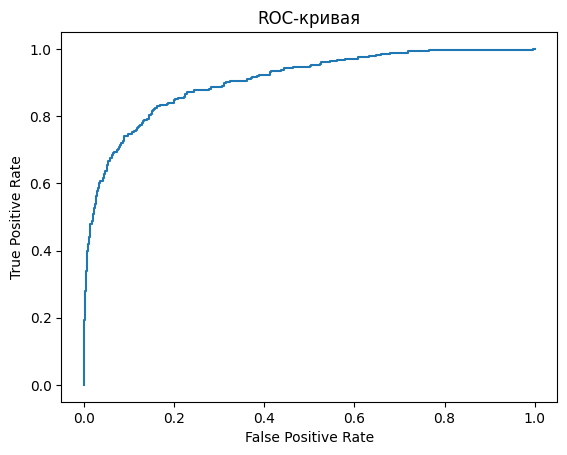

In [ ]:
fpr, tpr, _ = roc_curve(target_test, predict_proba[:, 1])

plt.plot(fpr,tpr)
plt.title('ROC-кривая')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Проверим модель на адекватность.

In [ ]:
dummy = DummyClassifier(random_state=RANDOM_STATE)
dummy.fit(features_train, target_train)
dummy_pred_proba = dummy.predict_proba(features_test)
print('ROC_AUC константной модели:', roc_auc_score(target_test, dummy_pred_proba[:, 1]))

ROC_AUC константной модели: 0.5


**Вывод**: Кривая выпукла в левый верхний угол, значит модель хорошо классифицирует данные по категориям. Площадь по ROC-кривой равна 0.91. ROC_AUC нашей модели больше чем у dummy-модели.
Цель исследования выполнена. Проведем итоговый анализ лучшей модели.

### Accuracy

Введем дополнительную метрику Accuracy для интерпретации модели заказчику.

In [ ]:
prediction = gs_boost.best_estimator_.predict(features_test)
print('Accuracy на тестовой выборке:', accuracy_score(target_test, prediction))

Accuracy на тестовой выборке: 0.9063032367972743


Наша модель правильно предсказывает уйдет клиент или нет в 91% случаев, что является достаточно хорошим результатом. Сравним с константной моделью.

In [ ]:
dummy_pred = dummy.predict(features_test)
print('Accuracy константной модели:', accuracy_score(target_test, dummy_pred))

Accuracy константной модели: 0.8438387279954571


Наша модель работает лучше чем константная модель, но точность константной модели не сильно меньше. Все из-за дисбаланса классов, т.к. отрицательный класс в большинстве. Но нам важно, чтобы модель могла находить положительный класс, т.е. людей которые увольняются. Рассмотрим работу модели на примере матрицы ошибок.

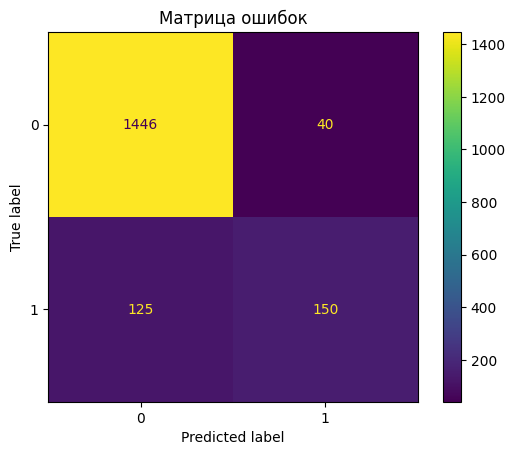

In [ ]:
matrix = confusion_matrix(target_test, prediction)
conf = ConfusionMatrixDisplay(confusion_matrix=matrix)
conf.plot()
plt.title('Матрица ошибок')
plt.show()

**Вывод:** Accuracy лучшей модели составляет 0.91. Этот результат оказался лучше чем у константной модели (0.84). Модель достаточно хорошо определяет что клиент останется, это объясняется тем, что это больший класс. Положительный класс (ушедшие) модель определяет хуже - 45% предсказано верно.

### Анализ важности признаков

Проведем анализ важности признаков.

In [ ]:
pd.Series(gs_boost.best_estimator_[-1].get_feature_importance(),
          index=[x.split('__')[-1] for x in gs_boost.best_estimator_[:-1].get_feature_names_out()]).sort_values(ascending=False)

duration             30.482698
total_charges        12.462412
monthly_charges      12.073262
type                  9.192278
payment_method        9.117194
partner               6.291213
multiple_lines        5.260325
device_protection     4.684995
streaming_movies      3.921333
online_backup         3.814147
senior_citizen        2.700142
dtype: float64

Самым важным признаком для расчета предсказаний является синтетический признак duration, за ним идут total_charges и monthly_charges. Значимость остальных признаков мала.

## Общий вывод

В данном исследовании мы анализировали персональные данные клиентов об их тарифах и услугах предоставленные компанией «ТелеДом». Им нужна модель, которая будет эффективно предсказывать, разорвет ли клиент договор с компанией (ROC_AUC >= 0.85).

В процессе предобработки мы выполнили следующие шаги:
1. Привели названия полей к "змеиному" регистру
2. изменили тип данных у следующих строк:
  - begin_date - datetime
  - end_date - datetime
  - total_charges - float
  - senior_citizen - object
3. Обработали пропуске в столбце `total_charges` значениями из `monthly_charges`
4. Объединили датафреймы
5. На основе столбца `end_date` создали целевую переменную
6. Обработали пропуски после объединения значением `other`
6. Создали новый признак - duration (длительность договора)

Аномалии обнаружены не были.

Дальше были рассмотрены три метода для построения модели и выбраны лучшие из них:

| Модель | Гиперпараметры | ROC_AUC |
| --- | --- | --- |
| Логистическая регрессия | {max_iter=1000} | 0.77
| Случайный лес | {'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__max_depth': 7} | 0.84
| Градиентный бустинг (CatBoost) | {'catboostclassifier__max_depth': 8, 'catboostclassifier__learning_rate': 0.1, 'catboostclassifier__iterations': 1000} | 0.90



Мы выполнили задачу (ROC_AUC >= 0.85) и выбрали на тестирование модель градиентного бустинга. На тестировании модель показала следующие результаты:

- ROC_AUC на тестовой выборке: 0.91
- Accuracy на тестовой выборке: 0.91

Данная модель прошла проверку на адекватность и показала лучшие результаты чем константная модель.
Она отправляется в производство.

Благодаря матрице ошибок мы поняли, что модель достаточно хорошо определяет что клиент останется, это объясняется тем, что это больший класс. Положительный класс (ушедшие) модель определяет хуже - 45% предсказано верно.

Также мы выянили что тремя самыми важными признаками для модели оказались:
- длительность договора
- общие расходы
- расходы за месяц

Рекомендации заказчику:

- разработан портрет уходящего клиента: препочитает пользоваться всем спектром услуг компании. Из-за этого средний чек больше чем у оставшихся клиентов. Это женатый клиент. Пенсионеры более склонны к уходу. Уходящий клиент склонен оплачивать услуги раз в год-два.

- проработать систему семейных тарифов, т.к. разрывают контракт около 20% женатых людей

- высокий процент ушедших клиентов пользовались всем спектром услуг компании. Нужно проверить соответствует ли заявленное качество предоставляемых услуг реальному

- требуется дообучить модель, т.к. она не достаточно хорошо предсказывает уход клиентов

